In [1]:
#https://leedakyeong.tistory.com/entry/Deep-Learning-for-Time-Series-Forecasting-kaggle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

#Set seeds to make the experiment more reproducible
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

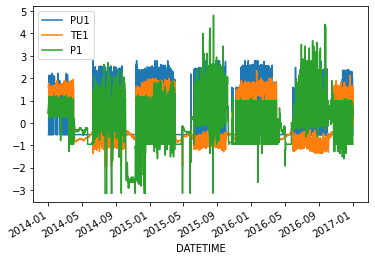

In [2]:
# https://blog.naver.com/chromatic_365/222657670527
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymysql
import matplotlib as mpl

# mysql db 연동
db = pymysql.connect(host='127.0.0.1',password='gkftndlTek!!',user='root',db='tp',charset='utf8', 
    cursorclass=pymysql.cursors.DictCursor)

cursor = db.cursor()

query = "select DATETIME, PU1, TE1, P1 from wholeData where DATETIME between '2014-01-01 00:00:00' and '2016-12-31 23:00:00'"
cursor.execute(query)
db_export = cursor.fetchall()

tp=pd.DataFrame(db_export)
#db_result_df = db_result_df.drop([db_result_df.columns[0]], axis=1) # 중복 index열 삭제

# scaling
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df
scale_columns = ['PU1', 'TE1', 'P1']

tp_df=standard_scaling(tp, scale_columns)
tp_df

tp_df.index=tp_df['DATETIME']
tp_df.set_index('DATETIME', inplace=True)
tp_df.plot()
plt.show()

# 5. Train/Valudation Split
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리한다.
# 'PU1'를 제외한 칼럼들은 x
x=tp_df[tp_df.columns.difference(['TE1'])]

y=tp_df['TE1']

# 검증(test)는 20%로 한다. = test_size=0.4
X_train, X_valid, y_train, y_valid=train_test_split(x,y,test_size=0.4,random_state=19)

In [3]:
print('Train set shape', X_train.shape)
print('Test set shape',X_valid.shape)

Train set shape (15758, 2)
Test set shape (10506, 2)


In [4]:
X_train_series=X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_valid_series=X_valid.values.reshape((X_valid.shape[0],X_valid.shape[1],1))

In [7]:
# 40번 반복학습하고, 한번에 256개씩 학습하며, learning rate는 0.0003으로 설정
# optimizer는 adam을 사용
epochs=40
batch=256
lr=0.0003
adam=optimizers.Adam(lr)

# Model Architecture
model_lstm=Sequential()
model_lstm.add(LSTM(50,activation='relu',input_shape=(X_train_series.shape[1],X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse',optimizer=adam)

In [8]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [9]:
lstm_history=model_lstm.fit(X_train_series, y_train, validation_data=(X_valid_series, y_valid),epochs=30,verbose=2)

Epoch 1/30
493/493 - 2s - loss: 0.9015 - val_loss: 0.8431 - 2s/epoch - 4ms/step
Epoch 2/30
493/493 - 1s - loss: 0.8019 - val_loss: 0.7761 - 1s/epoch - 2ms/step
Epoch 3/30
493/493 - 1s - loss: 0.7479 - val_loss: 0.7326 - 1s/epoch - 2ms/step
Epoch 4/30
493/493 - 1s - loss: 0.7184 - val_loss: 0.7111 - 1s/epoch - 2ms/step
Epoch 5/30
493/493 - 1s - loss: 0.7034 - val_loss: 0.7004 - 1s/epoch - 2ms/step
Epoch 6/30
493/493 - 1s - loss: 0.6936 - val_loss: 0.6903 - 1s/epoch - 2ms/step
Epoch 7/30
493/493 - 1s - loss: 0.6864 - val_loss: 0.6841 - 1s/epoch - 2ms/step
Epoch 8/30
493/493 - 1s - loss: 0.6802 - val_loss: 0.6785 - 1s/epoch - 2ms/step
Epoch 9/30
493/493 - 1s - loss: 0.6754 - val_loss: 0.6745 - 1s/epoch - 2ms/step
Epoch 10/30
493/493 - 1s - loss: 0.6712 - val_loss: 0.6718 - 1s/epoch - 2ms/step
Epoch 11/30
493/493 - 1s - loss: 0.6687 - val_loss: 0.6709 - 1s/epoch - 2ms/step
Epoch 12/30
493/493 - 1s - loss: 0.6659 - val_loss: 0.6684 - 1s/epoch - 2ms/step
Epoch 13/30
493/493 - 1s - loss: 0.66

In [11]:
lstm_train_pred=model_lstm.predict(X_train.values)
lstm_valid_pred=model_lstm.predict(X_valid.values)

Y_train=pd.DataFrame({'y_true':y_train,'y_pred':
                     lstm_train_pred.reshape(lstm_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train=pd.merge(Y_train,tp_df,left_index=True,right_index=True,how='left')

Y_valid=pd.DataFrame({'y_true':y_valid,'y_pred':
                     lstm_valid_pred.reshape(lstm_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid=pd.merge(Y_valid,tp_df,left_index=True,right_index=True,how='left')

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymysql
import matplotlib as mpl
from sklearn import metrics

def scoring(y_true,y_pred):
    r2=round(metrics.r2_score(y_true,y_pred)*100,3)
    
    corr=round(np.corrcoef(y_true,y_pred)[0,1],3)
    mape=round(metrics.mean_absolute_percentage_error(y_true,y_pred)*100,3)
    rmse=round(metrics.mean_squared_error(y_true,y_pred,squared=False),3)
    
    df=pd.DataFrame({
        'R2':r2,
        "Corr":corr,
        "RMSE":rmse,
        "MAPE":mape
    },
    index=[0])
    return df

In [13]:
scoring(Y_train.y_true, Y_train.y_pred)

,R2,Corr,RMSE,MAPE
0,35.162,0.593,0.805,86.972


In [14]:
scoring(Y_valid.y_true, Y_valid.y_pred)

,R2,Corr,RMSE,MAPE
0,34.445,0.587,0.81,78.112


In [15]:
temp=Y_valid.loc[(Y_valid.PU1<=1)&(Y_valid.TE1>=-1)&(Y_valid.P1>=0),].sort_values('DATETIME')
#temp=Y_test.sort_values('DATETIME')
print("Obs of Test Set :",temp.shape[0])

Obs of Test Set : 3383


In [16]:
scoring(temp.y_true, temp.y_pred)

,R2,Corr,RMSE,MAPE
0,6.797,0.277,0.939,76.841


In [17]:
def abline(slope,intercept):
    axes=plt.gca()
    x_vals=np.array(axes.get_xlim())
    y_vals=intercept+slope*x_vals
    plt.plot(x_vals,y_vals,'--')
    
def MinMax(y_true,y_pred,m="min"):
    if(m=="min"):
        return min(min(y_true),min(y_pred))-2
    else:
        return max(max(y_true),max(y_pred))+2
    
def myGraph(temp,title,index):
    fig,axs=plt.subplots(1,2,figsize=(17,4))

    axs[0].plot(temp.index,temp.y_true,label="Original")
    axs[0].plot(temp.index,temp.y_pred,label="Predicted")
    
    axs[0].legend(loc='upper right')
    axs[0].title.set_text('TE1_predicted')
    axs[0].set_xlabel("DATETIME")
    axs[0].set_ylabel("TE1")
    
    axs[1].plot(temp.y_true,temp.y_pred,'.')
    
    plt.xlim(MinMax(temp.y_true,temp.y_pred),MinMax(temp.y_true,temp.y_pred,"max"))

    plt.ylim(MinMax(temp.y_true,temp.y_pred),MinMax(temp.y_true,temp.y_pred,"max"))
    abline(1,0)
    plt.title('TE1_predicted')
    plt.xlabel("Original")
    plt.ylabel("Predicted")

    plt.show()

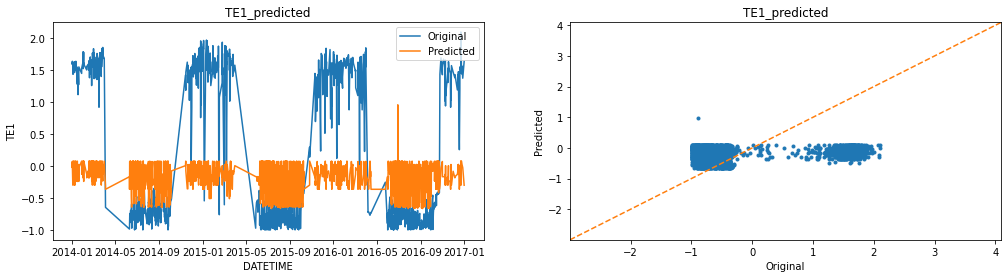

In [18]:
myGraph(temp,'LSTM TE1','DATETIME')